# **Waze Project**
**The nuts and bolts of machine learning**

Your team is close to completing their user churn project. Previously, you completed a project proposal, and used Python to explore and analyze Waze’s user data, create data visualizations, and conduct a hypothesis test. Most recently, you built a binomial logistic regression model based on multiple variables.

Leadership appreciates all your hard work. Now, they want your team to build a machine learning model to predict user churn. To get the best results, your team decides to build and test two tree-based models: random forest and XGBoost.

Your work will help leadership make informed business decisions to prevent user churn, improve user retention, and grow Waze’s business.


# **Build a machine learning model**


<img src="images/Pace.png" width="100" height="100" align=left>

# **PACE stages**



## **PACE: Plan**



### **Imports and data loading**

Importing packages and libraries needed to build and evaluate random forest and XGBoost classification models.

In [92]:
# Packages for data manipulation
import numpy as np
import pandas as pd

# Packages for data visualization
import matplotlib.pyplot as plt

# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

# Packages for data modeling
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# This is the function that helps plot feature importance
from xgboost import plot_importance

# This module lets us save our models once we fit them.
import pickle

In [93]:
# Importing dataset
df0 = pd.read_csv('waze_dataset.csv')

In [94]:
# Inspecting the first five rows
df0.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android




## **PACE: Analyze**


### **Feature engineering**


In [95]:
# Copying the df0 dataframe
df = df0.copy()

Calling `info()` on the new dataframe so the existing columns can be easily referenced.

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


#### **`km_per_driving_day`**



In [97]:
# Creating `km_per_driving_day` feature
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

# Getting descriptive stats
df['km_per_driving_day'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

Notice that some values are infinite. This is the result of there being values of zero in the `driving_days` column. Pandas imputes a value of infinity in the corresponding rows of the new column because division by zero is undefined.


In [98]:
# Converting infinite values to zero
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0

# Confirming that it worked
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

#### **`percent_sessions_in_last_month`**


In [99]:
# Creating `percent_sessions_in_last_month` feature
df['percent_sessions_in_last_month'] = df['sessions'] / df['total_sessions']

# Getting descriptive stats
df['percent_sessions_in_last_month'].describe()

count    14999.000000
mean         0.449255
std          0.286919
min          0.000000
25%          0.196221
50%          0.423097
75%          0.687216
max          1.530637
Name: percent_sessions_in_last_month, dtype: float64

#### **`professional_driver`**


In [101]:
# Creating `professional_driver` feature
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)

#### **`total_sessions_per_day`**


In [102]:
# Creating `total_sessions_per_day` feature
df['total_sessions_per_day'] = df['total_sessions'] / df['n_days_after_onboarding']

Descriptive statistics.

In [103]:
# Getting descriptive stats
df['total_sessions_per_day'].describe()

count    14999.000000
mean         0.338698
std          1.314333
min          0.000298
25%          0.051037
50%          0.100775
75%          0.216269
max         39.763874
Name: total_sessions_per_day, dtype: float64

#### **`km_per_hour`**


In [104]:
# Creating `km_per_hour` feature
df['km_per_hour'] = df['driven_km_drives'] / (df['duration_minutes_drives'] / 60)
df['km_per_hour'].describe()

count    14999.000000
mean       190.394608
std        334.674026
min         72.013095
25%         90.706222
50%        122.382022
75%        193.130119
max      23642.920871
Name: km_per_hour, dtype: float64

#### **`km_per_drive`**


In [105]:
# Creating `km_per_drive` feature
df['km_per_drive'] = df['driven_km_drives'] / df['drives']
df['km_per_drive'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      1.008775e+00
25%      3.323065e+01
50%      7.488006e+01
75%      1.854667e+02
max               inf
Name: km_per_drive, dtype: float64

This feature has infinite values too. 

In [106]:
# Converting infinite values to zero
df.loc[df['km_per_drive']==np.inf, 'km_per_drive'] = 0

# Confirming that it worked
df['km_per_drive'].describe()

count    14999.000000
mean       232.817946
std        620.622351
min          0.000000
25%         32.424301
50%         72.854343
75%        179.347527
max      15777.426560
Name: km_per_drive, dtype: float64

#### **`percent_of_sessions_to_favorite`**
This is a proxy representation for the percent of overall drives that are to a favorite place. Since total drives since onboarding are not contained in this dataset, total sessions must serve as a reasonable approximation.

People whose drives to non-favorite places make up a higher percentage of their total drives might be less likely to churn, since they're making more drives to less familiar places.

In [107]:
# Creating `percent_of_sessions_to_favorite` feature
df['percent_of_drives_to_favorite'] = (
    df['total_navigations_fav1'] + df['total_navigations_fav2']) / df['total_sessions']

# Getting descriptive stats
df['percent_of_drives_to_favorite'].describe()

count    14999.000000
mean         1.665439
std          8.865666
min          0.000000
25%          0.203471
50%          0.649818
75%          1.638526
max        777.563629
Name: percent_of_drives_to_favorite, dtype: float64

### **Drop missing values**

From previous EDA, there is no evidence of a non-random cause of the 700 missing values in the `label` column, and these observations comprise less than 5% of the data, so I'm using the `dropna()` method to drop the rows that are missing this data.

In [108]:
# Dropping rows with missing values
df = df.dropna(subset=['label'])

### **Outliers**

Tree-based models are resilient to outliers, so there is no need to make any imputations.

### **Variable encoding**

#### **Dummying features**

Creating a new, binary column called `device2` that encodes user devices as follows:

* `Android` -> `0`
* `iPhone` -> `1`

In [167]:
# Creating new `device2` variable
df['device2'] = np.where(df['device']=='Android', 0, 1)
df[['device', 'device2']].tail()

,device,device2
14994,iPhone,1
14995,Android,0
14996,iPhone,1
14997,iPhone,1
14998,iPhone,1


#### **Target encoding**

The target variable is also categorical, since a user is labeled as either "churned" or "retained." 
Changing the data type of the `label` column to be binary.

Assign a `0` for all `retained` users.

Assign a `1` for all `churned` users.

Saving this variable as `label2`.


In [110]:
# Creating binary `label2` column
df['label2'] = np.where(df['label']=='churned', 1, 0)
df[['label', 'label2']].tail()

,label,label2
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1
14998,retained,0


### **Feature selection**

Tree-based models can handle multicollinearity, so the only feature that can be cut is `ID`, since it doesn't contain any information relevant to churn.


In [111]:
# Drop `ID` column
df = df.drop(['ID'], axis=1)

### **Evaluation metric**


In [112]:
# Getting class balance of 'label' col
df['label'].value_counts(normalize=True)

label
retained    0.822645
churned     0.177355
Name: proportion, dtype: float64

Approximately 18% of the users in this dataset churned. This is an unbalanced dataset, but not extremely so. It can be modeled without any class rebalancing.



## **PACE: Construct**

### **Split the data**


In [113]:
# Isolating X variables
X = df.drop(columns=['label', 'label2', 'device'])

# Isolating y variable
y = df['label2']

# Splitting into train and test sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, stratify=y,
                                              test_size=0.2, random_state=42)

# Splitting into train and validate sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, stratify=y_tr,
                                                  test_size=0.25, random_state=42)

Verifying the number of samples in the partitioned data.

In [114]:
for x in [X_train, X_val, X_test]:
    print(len(x))

8579
2860
2860


This aligns with expectations.

### **Modeling**

#### **Random forest**

In [115]:
# Instantiating the random forest classifier
rf = RandomForestClassifier(random_state=42)

# Creating a dictionary of hyperparameters to tune
cv_params = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [1.0],
             'min_samples_leaf': [2],
             'min_samples_split': [2],
             'n_estimators': [300],
             }

# Defining a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiating the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='recall')

Fitting the model to the training data.

In [116]:
%%time
rf_cv.fit(X_train, y_train)

CPU times: user 1min 57s, sys: 88 ms, total: 1min 57s
Wall time: 1min 57s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [1.0], 'min_samples_leaf': [2],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='recall', scoring={'accuracy', 'precision', 'recall', 'f1'})

Examining the best average score across all the validation folds.

In [117]:
# Examining best score
rf_cv.best_score_

0.12678201409034398

Examine the best combination of hyperparameters.

In [118]:
# Examining best hyperparameter combo
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

Using the `make_results()` function to output all of the scores of your model.

In [130]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

   # Creating dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    # Getting all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

   # Extracting accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Creating table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

In [131]:
results = make_results('RF cv', rf_cv, 'recall')
results

,model,precision,recall,F1,accuracy
0,RF cv,0.457163,0.126782,0.198445,0.81851


Asside from the accuracy, the scores aren't that good. However, recall that when you built the logistic regression model in the last course the recall was \~0.09, which means that this model has 33% better recall and about the same accuracy, and it was trained on less data.


#### **XGBoost**



In [132]:
# Instantiating the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# Creating a dictionary of hyperparameters to tune
cv_params = {'max_depth': [6, 12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300]
             }

# Defining a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}


# Instantiating the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='recall')

Fitting the model to the `X_train` and `y_train` data.


In [133]:
%%time
xgb_cv.fit(X_train, y_train)


CPU times: user 4min 34s, sys: 1.92 s, total: 4min 36s
Wall time: 2min 20s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 12],
                         'min_child_weight': [3, 5], 'n_estimators': [300]},
             refit='recall', scoring={'accuracy', 'precision', 'recall', 'f1'})

Getting the best score from this model.

In [168]:
# Examining best score
xgb_cv.best_score_

0.1734683657963807

And the best parameters.

In [169]:
# Examining best parameters
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 12,
 'min_child_weight': 3,
 'n_estimators': 300}

Outputing all of the scores of your model.

In [170]:
# Calling 'make_results()' on the GridSearch object
xgb_cv_results = make_results('XGB cv', xgb_cv, 'recall')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.457163,0.126782,0.198445,0.81851
0,XGB cv,0.442586,0.173468,0.248972,0.81478
0,XGB cv,0.442586,0.173468,0.248972,0.81478
0,XGB cv,0.442586,0.173468,0.248972,0.81478
0,XGB cv,0.442586,0.173468,0.248972,0.81478
0,XGB cv,0.442586,0.173468,0.248972,0.81478


This model fit the data even better than the random forest model. The recall score is nearly double the recall score from the logistic regression model from the previous course, and it's almost 50% better than the random forest model's recall score, while maintaining a similar accuracy and precision score.

### **Model selection**


#### **Random forest**

In [171]:
# Using random forest model to predict on validation data
rf_val_preds = rf_cv.best_estimator_.predict(X_val)

Generating a table of scores from the predictions on the validation data.

In [172]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [173]:
# Getting validation scores for RF model
rf_val_scores = get_test_scores('RF val', rf_val_preds, y_val)

# Appending to the results table
results = pd.concat([results, rf_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.457163,0.126782,0.198445,0.818510
0,XGB cv,0.442586,0.173468,0.248972,0.814780
0,XGB cv,0.442586,0.173468,0.248972,0.814780
0,XGB cv,0.442586,0.173468,0.248972,0.814780
0,XGB cv,0.442586,0.173468,0.248972,0.814780
0,XGB cv,0.442586,0.173468,0.248972,0.814780
0,RF val,0.445255,0.120316,0.189441,0.817483


Notice that the scores went down from the training scores across all metrics, but only by very little. This means that the model did not overfit the training data.

#### **XGBoost**


In [174]:
# Using XGBoost model to predict on validation data
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)

# Getting validation scores for XGBoost model
xgb_val_scores = get_test_scores('XGB val', xgb_val_preds, y_val)

# Appending to the results table
results = pd.concat([results, xgb_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.457163,0.126782,0.198445,0.818510
0,XGB cv,0.442586,0.173468,0.248972,0.814780
0,XGB cv,0.442586,0.173468,0.248972,0.814780
0,XGB cv,0.442586,0.173468,0.248972,0.814780
0,XGB cv,0.442586,0.173468,0.248972,0.814780
0,XGB cv,0.442586,0.173468,0.248972,0.814780
0,RF val,0.445255,0.120316,0.189441,0.817483
0,XGB val,0.430769,0.165680,0.239316,0.813287


Just like with the random forest model, the XGBoost model's validation scores were lower, but only very slightly. It is still the clear champion.


## **PACE: Execute**

### **Using champion model to predict on test data**


In [182]:
# Using XGBoost model to predict on test data
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

# Getting test scores for XGBoost model
xgb_test_scores = get_test_scores('XGB test', xgb_test_preds, y_test)

# Appending to the results table
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.457163,0.126782,0.198445,0.818510
0,XGB cv,0.442586,0.173468,0.248972,0.814780
0,XGB cv,0.442586,0.173468,0.248972,0.814780
0,XGB cv,0.442586,0.173468,0.248972,0.814780
0,XGB cv,0.442586,0.173468,0.248972,0.814780
0,XGB cv,0.442586,0.173468,0.248972,0.814780
0,RF val,0.445255,0.120316,0.189441,0.817483
0,XGB val,0.430769,0.165680,0.239316,0.813287
0,XGB test,0.388889,0.165680,0.232365,0.805944
0,XGB test,0.388889,0.165680,0.232365,0.805944


The recall was exactly the same as it was on the validation data, but the precision declined notably, which caused all of the other scores to drop slightly. Nonetheless, this is stil within the acceptable range for performance discrepancy between validation and test scores.

### **Confusion matrix**

Plotting a confusion matrix of the champion model's predictions on the test data.

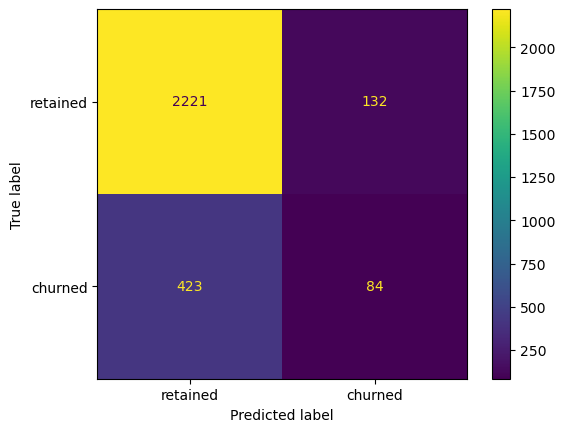

In [183]:
# Generating array of values for confusion matrix
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)

# Plotting confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['retained', 'churned'])
disp.plot();

The model predicted three times as many false negatives than it did false positives, and it correctly identified only 16.6% of the users who actually churned.

### **Feature importance**


In [ ]:
plot_importance(xgb_cv.best_estimator_)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

### **Conclusion**


The model's suitability depends on its intended use. If it's meant for making important business decisions, it's not recommended due to its weak predictive performance, evident from its low recall score. However, if it's solely for guiding exploratory efforts, it can be valuable.

Splitting the data into three parts reduces the amount available for model training compared to a two-way split. However, this approach allows for model selection on a separate validation set, providing a more accurate estimate of future performance compared to a two-way split based on test data performance.

Logistic regression models are simpler to interpret. They assign coefficients to predictor variables, revealing not only which features had the most influence on predictions but also the direction of that influence, indicating whether each feature is positively or negatively correlated with the target in the model's prediction.

Tree-based model ensembles are often superior predictors. If predictive power is the top priority, tree-based models generally outperform logistic regression, although not always. They also require less data cleaning and make fewer assumptions about the underlying distributions of predictor variables, making them more user-friendly.

To enhance the model's performance, you can create new features, particularly if you have domain knowledge. In this model, engineered features accounted for more than half of the top 10 most influential features. Another approach is to rebuild the model using different combinations of predictor variables to reduce noise from less predictive features.

To improve the model, having detailed drive-level information for each user (e.g., drive times, locations) would be beneficial. Additionally, more granular data on user interactions with the app, such as the frequency of reporting or confirming road hazards, could provide valuable insights. Finally, having information about the monthly count of unique starting and ending locations input by each driver would be helpful.